This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [1]:
#%run 0_parameters.ipynb

In [2]:
from where import Where
from what import WhatNet
from retina import Retina
import torch
import torch.nn.functional as F

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Training the Where network

In [4]:
%ls -lh ../data/*pt

-rw-r--r-- 1 dauce dauce 6,9M mars  28 08:04 ../data/2019-03-27_train.pt
-rw-r--r-- 1 dauce dauce 6,9M mars  28 20:40 ../data/2019-03-28_train.pt
-rw-r--r-- 1 dauce dauce 7,8M avril  3 13:02 ../data/2019-04-03_train.pt
-rw-r--r-- 1 dauce dauce 7,8M avril  5 00:03 ../data/2019-04-04_train.pt
-rw-r--r-- 1 dauce dauce  12M avril  6 00:30 ../data/2019-04-05_train.pt
-rw-r--r-- 1 dauce dauce  12M avril  6 02:18 ../data/2019-04-06_train.pt
-rw-r--r-- 1 dauce dauce 1,7M juin  16 00:32 ../data/MNIST_cnn_0.1_0.1_1.0_0.3.pt
-rw-r--r-- 1 dauce dauce 1,7M juin  12 12:03 ../data/MNIST_cnn_0.5_0.5_1.0_0.7.pt
-rw-r--r-- 1 dauce dauce 1,7M avril  6 01:45 ../data/MNIST_cnn.pt
-rw-r--r-- 1 dauce dauce 1,7M juin  30 09:05 ../data/MNIST_cnn_robust_0.1_0.1_1.0_0.7.pt
-rw-r--r-- 1 dauce dauce 1,7M juin  21 09:42 ../data/MNIST_cnn_robust_what_0.1_0.1_1.0_0.1_5epoques_2019-06-20_14h05.pt
-rw-r--r-- 1 dauce dauce 1,7M juin  27 16:21 ../data/MNIST_cnn_robust_what_0.1_0.1_1.0_0.2_5epoques_2019-06-20_13h58.pt
-rw

In [5]:
from main import init
#args = init(filename='debug')
#args = init(filename='../data/2019-03-19_bis')
args = init(filename='../data/2019-06-13')
#args = init(filename='../data/2019-03-29')

args.save_model = True
period = 10
args.sf_0 = 1/period
args.B_sf = 1/period
args.contrast = 0.7
args.offset_std = 30
'''args.bn1_bn_momentum = 0
args.bn2_bn_momentum = 0
args.p_dropout = 0.5
args.lr = 1e-4
args.dim1 = 1000
args.dim2 = 1000
args.epochs = 60
args.verbose = True
args.save_model = True'''


'args.bn1_bn_momentum = 0\nargs.bn2_bn_momentum = 0\nargs.p_dropout = 0.5\nargs.lr = 1e-4\nargs.dim1 = 1000\nargs.dim2 = 1000\nargs.epochs = 60\nargs.verbose = True\nargs.save_model = True'

In [68]:
nb_saccades = 1
linear = True
if linear:
    figname = '../paper/fig_result_robust_contrast_linear_{:.1f}_{}'.format(args.contrast, nb_saccades)
else:
    figname = '../paper/fig_result_robust_contrast_{:.1f}_{}'.format(args.contrast, nb_saccades)


In [7]:
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 40,
 'noise': 1.0,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.5,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.0001,
 'do_adam': True,
 'bn1_bn_momentum': 0.0,
 'bn2_bn_momentum': 0.0,
 'momentum': 0.0,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-13',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

In [8]:
if False:
    !rm ../data/2019-04-05_train.pt


In [9]:
args.epochs = 60

In [10]:
from what import What 
what_suffix = "robust_{}_{}_{}_{}".format(args.sf_0, args.B_sf, args.noise, args.contrast)
what_model_path = "../data/MNIST_cnn_{}.pt".format(what_suffix)
what_model = torch.load(what_model_path)
args.what_offset_max = 25
args.what_offset_std = 10
what = What(args, model=what_model)
acc = what.trainer.test()



Test set: Average loss: 0.0120, Accuracy: 5842/10000 (58%)



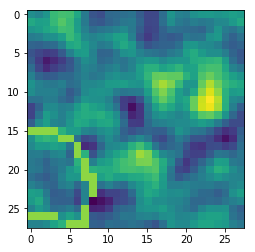

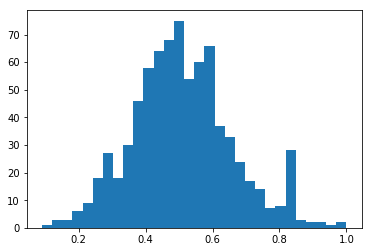

In [11]:
data, target = next(iter(what.trainer.test_loader))
plt.imshow(data[0,:,:].reshape((28,28)))
plt.show()
_ = plt.hist(data[0,:,:].detach().numpy().flatten(), 30)

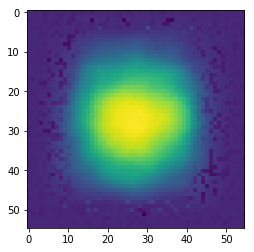

In [12]:
acc_map_path = "../data/MNIST_accuracy_{}.npy".format(what_suffix)
#print(acc_map_path)
acc_map = np.load(acc_map_path)  
plt.imshow(acc_map)

In [13]:
#args.train_batch_size = 20
#args.test_batch_size = 20
#retina = Retina(args)


#plt.show()
#_ = plt.plot(acc_map)
where = Where(args, what_model=what_model, acc_map=acc_map, robust=True) #, generate_data=False) #False, save = False)

#filename_train = args.filename + '_train.pt'
#filename_train = "../data/2019-03-14_train4.pt"
#filename_train = "../data/2019-03-29.pt"
#%ls -lh {filename_train}
#%rm {filename_train}
#%rm  ../data/debug_train.pt

#where.train(filename_train)

Loading training dataset
Loading testing dataset


In [14]:
what_model

WhatNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [15]:
where.model

WhereNet(
  (bn1): Linear(in_features=2880, out_features=1000, bias=True)
  (bn1_bn): BatchNorm1d(1000, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
  (bn2): Linear(in_features=1000, out_features=1000, bias=True)
  (bn2_bn): BatchNorm1d(1000, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
  (bn3): Linear(in_features=1000, out_features=240, bias=True)
)

In [16]:
#test_loader = torch.load('/tmp/where_test_dataset__robust_0.1_0.1_1.0_0.7_30_40_6_24_10_2_1.41_128_100.pt')

In [17]:
retina_data, accuracy_colliculus = next(iter(where.loader_train))
#retina_data, accuracy_colliculus = next(iter(train_loader))

In [18]:
#from where import Normalize
#retina_data = Normalize()(retina_data.float())


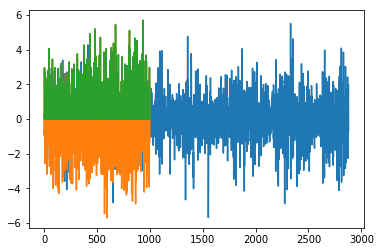

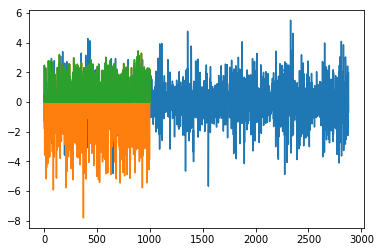

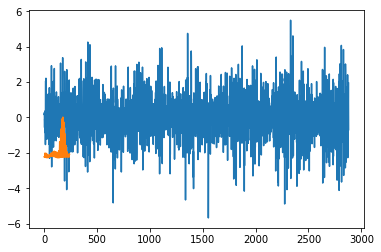

In [19]:
i = 3
data_i = retina_data[i,:].float()
plt.plot(data_i.detach().numpy())
x = where.model.bn1(data_i)
plt.plot(x.detach().numpy())
x = F.relu(x)
plt.plot(x.detach().numpy())
plt.show()
x2 = where.model.bn2(x)
plt.plot(data_i.detach().numpy())
plt.plot(x2.detach().numpy())
x2 = F.relu(x2)
plt.plot(x2.detach().numpy())
plt.show()
x3 = where.model.bn3(x2)
plt.plot(data_i.detach().numpy())
plt.plot(x3.detach().numpy())
#plt.plot(where.model.bn1(retina_data.float())[i,:].detach().numpy())

In [20]:
import torch

output = torch.sigmoid(where.model(retina_data))
output_test = where.pred_accuracy(retina_data)

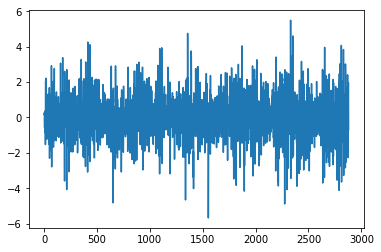

In [21]:
plt.plot(retina_data[i,:].detach().numpy())

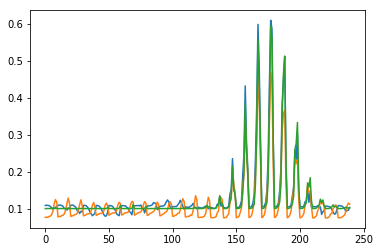

In [22]:
plt.plot(output[i, :].detach().numpy())
plt.plot(output_test[i, :])
plt.plot(accuracy_colliculus[i, :].detach().numpy())

In [23]:
#retina_data_test, retina_fullfield_test, accuracy_colliculus_test, accuracy_colliculus_fullfield_test, labels_test, i_shift, j_shift = next(iter(test_loader))
retina_data_test, retina_fullfield_test, accuracy_colliculus_test, accuracy_colliculus_fullfield_test, labels_test, i_shift, j_shift = next(iter(where.loader_test))
#(retina_data_test, retina_fullfield_test), (accuracy_colliculus_test, accuracy_colliculus_fullfield_test, labels_test, i_shift, j_shift) = next(iter(where.loader_test))

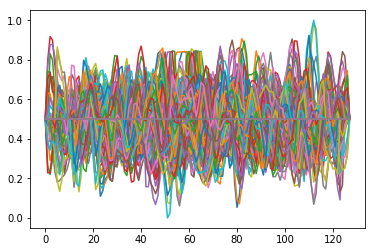

In [24]:
i = 0
_ = plt.plot(retina_fullfield_test[i,:].detach().numpy())

In [25]:
#plt.plot(data[i,:].detach().numpy())

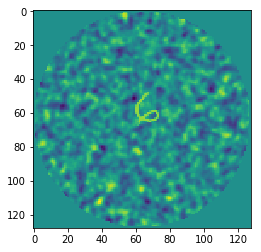

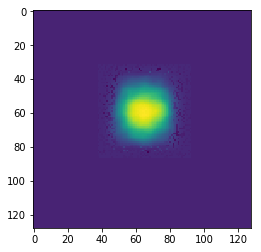

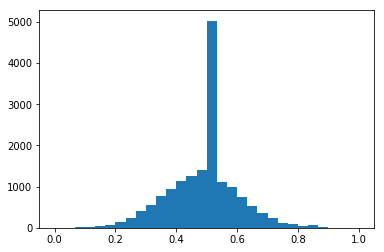

In [26]:
plt.imshow(retina_fullfield_test[i,:])
plt.show()
plt.imshow(accuracy_colliculus_fullfield_test[i,:])
plt.show()
h = plt.hist(retina_fullfield_test[i,:,:].detach().numpy().flatten(), 30)

In [27]:
output = torch.sigmoid(where.model(retina_data_test.float()))

Text(0.5, 1.05, 'True')

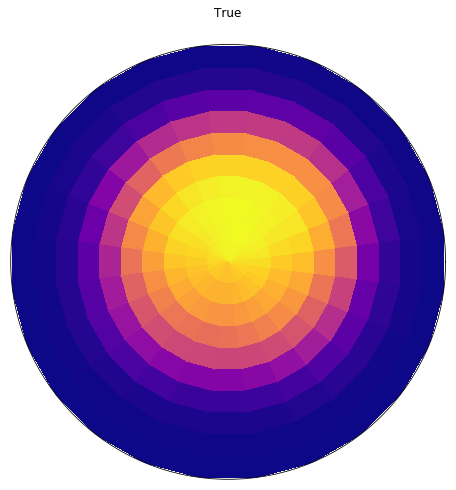

In [28]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='polar')
ax.pcolor(where.retina.theta_grid, where.retina.log_r_grid, accuracy_colliculus_test[i, :].detach().numpy().reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title("True")

Text(0.5, 1.05, 'predicted')

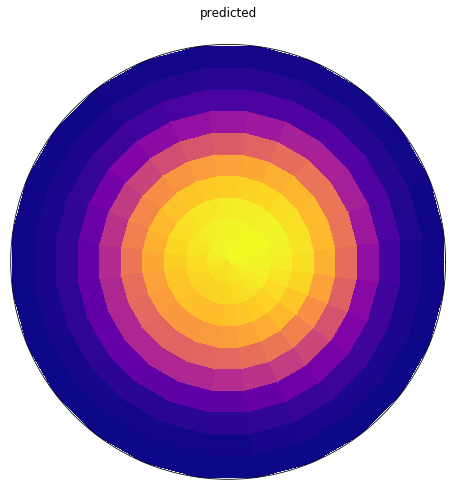

In [29]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='polar')
ax.pcolor(where.retina.theta_grid, where.retina.log_r_grid, output[i, :].detach().numpy().reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title("predicted")

# Visualisation of some examples

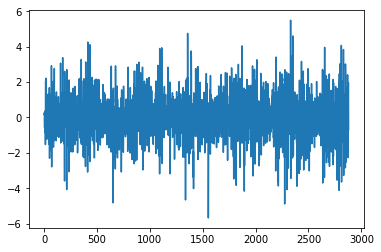

In [30]:
i = 3
plt.plot(retina_data[i,:].detach().numpy())

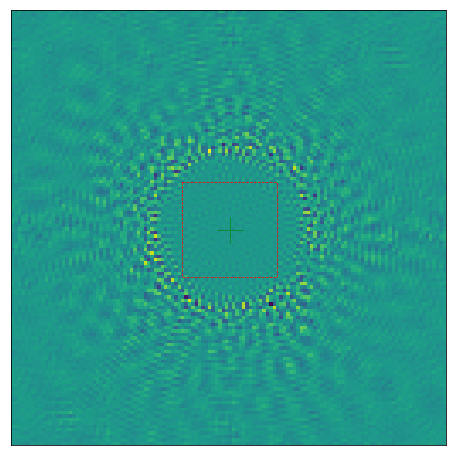

In [31]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
ax = where.retina.show(ax, where.retina.retina_invert(retina_data[i,:].detach().numpy()))


Text(0.5, 1.05, 'True')

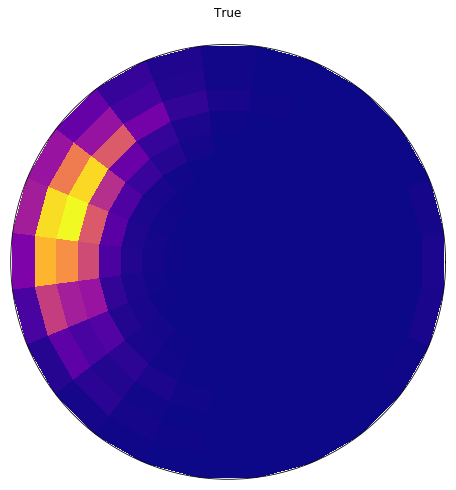

In [32]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='polar')
ax.pcolor(where.retina.theta_grid, where.retina.log_r_grid, accuracy_colliculus[i, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title("True")

In [33]:
retina_data

tensor([[-0.3693, -0.0509,  0.0061,  ..., -2.8221,  1.0809,  3.0965],
        [-0.1637, -0.0309,  0.0675,  ..., -1.5505, -0.0081,  1.7048],
        [ 0.3296, -0.1666, -0.2587,  ...,  0.8390,  0.3566, -1.7292],
        ...,
        [ 0.1151, -0.0599,  0.0171,  ...,  0.0697,  1.8945, -0.5914],
        [ 0.1018,  0.0048,  0.0739,  ..., -0.0731, -1.1175,  0.7193],
        [ 0.1099, -0.0889, -0.2165,  ..., -1.0250,  0.5879,  0.8629]])

In [34]:
min(accuracy_colliculus[3,:])

tensor(0.1000)

In [35]:
print(accuracy_colliculus.shape)
print(args.N_azimuth)
print(args.N_eccentricity) 

print(where.args.N_azimuth)
print(where.args.N_eccentricity) 

torch.Size([100, 240])
24
10
24
10


## knowing the target position

In [36]:
idx_start, idx_stop = 0, 20


In [37]:
#positions, data_fullfield, retina_data, accuracy_colliculus = where.minibatch(data[idx_start:idx_stop])
#positions, data_fullfield, retina_data, accuracy_colliculus = where.minibatch(None) #data[idx_start:idx_stop])

In [38]:
retina_data, data_fullfield, accuracy_colliculus, _, label, i_offset, j_offset = next(iter(where.loader_test))

0.9304254

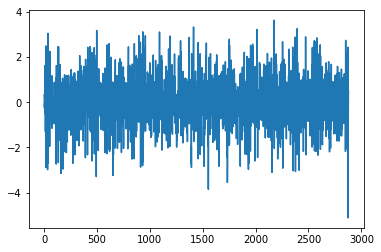

In [39]:
plt.plot(retina_data[i,:].detach().numpy())
np.std(retina_data[i,:].detach().numpy())

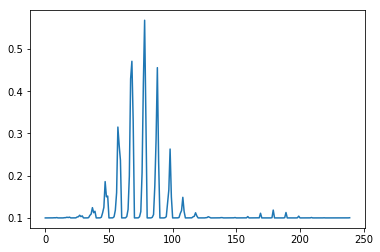

In [40]:
plt.plot(accuracy_colliculus[i,:].detach().numpy())

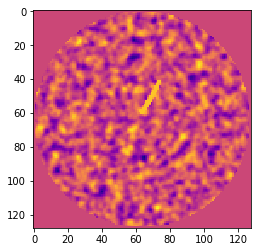

In [41]:
plt.imshow(data_fullfield[2,:])

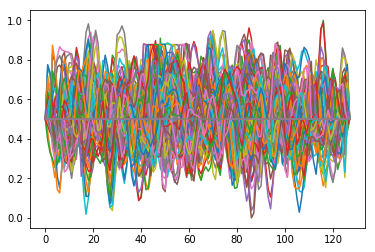

In [42]:
_ = plt.plot(data_fullfield[2,:].detach().numpy())
#data_fullfield *= 255

In [44]:
import numpy as np
Delta=0

#im = np.zeros((args.test_batch_size, args.w, args.w))
im = np.zeros((idx_stop, where.args.w, where.args.w))
for idx in range(idx_stop): #args.test_batch_size):
    #im[idx, :, :] = where.extract(data_fullfield[idx, :, :], positions[idx]['i_offset'], positions[idx]['j_offset'])
    im[idx, :, :] = where.extract(data_fullfield[idx+Delta, :, :], i_offset[idx+Delta], j_offset[idx+Delta])
proba = where.classify_what(im).detach().numpy()
pred = proba.argmax(axis=1)# get the index of the max log-probability
#acc = proba[:, pred]

print(pred)
label_n = label[idx_start+Delta:idx_stop+Delta].detach().numpy()
print(label_n)
print(np.mean(np.equal(pred, label_n)))

#.detach().numpy().mean() #(pred==label.numpy()).mean()
#print('Accuracy max (knowing the position)=', acc_max)

[7 8 1 0 0 5 9 1 2 3 9 4 5 4 1 1 5 2 3 0]
[7 8 1 0 0 5 9 1 2 3 9 4 5 4 1 1 5 2 3 0]
1.0


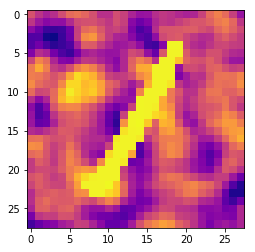

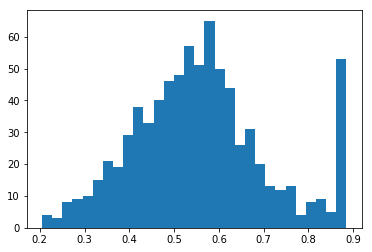

In [45]:
i = 2
plt.imshow(im[i,:,:])
plt.show()
_ = plt.hist(im[i,:,:].flatten(), 30)

## Generate a noisy MNIST database

In [46]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import os

#im = np.zeros((args.test_batch_size, args.w, args.w))

from display import get_data_loader
filename_dataset = '../data/noisy-MNIST.pt'

if not os.path.isfile(filename_dataset):
    batch_size = 100
    loader_full = get_data_loader(batch_size=batch_size, train=True, mean=where.args.mean, std=where.args.std, seed=where.args.seed+1)
    im = np.zeros((where.args.train_batch_size, 1, where.args.w, where.args.w))
    im_label = np.zeros(where.args.train_batch_size, dtype = 'int')
    for idx, (data, label) in enumerate (loader_full):
        if idx % 10 == 0:
            print(idx * 100)
        if idx == 500:
            break
        for j in range(batch_size):
            data_fullfield_, i_offset, j_offset = where.display.draw(data[j, 0, :, :].numpy())
            extracted = where.extract(data_fullfield_, i_offset, j_offset)
            im[idx * batch_size + j, 0, :, :] = extracted.reshape(1, 28, 28)
            im_label[idx * batch_size + j] = label[j]
    im = Variable(torch.FloatTensor(im)).to(where.device)
    im_label = Variable(torch.LongTensor(im_label)).to(where.device)
    loader_train = DataLoader(TensorDataset(im, im_label), batch_size=100)
    torch.save(loader_train, filename_dataset)
#.detach().numpy().mean() #(pred==label.numpy()).mean()
#print('Accuracy max (knowing the position)=', acc_max)

In [47]:
if False:
    check_loader = torch.load(filename_dataset)
    im, label = next(iter(check_loader))
    im.shape
    i = 4
    plt.imshow(im[i,0,:,:])
    plt.title(label[i].detach().numpy())

tensor(8) tensor(1) tensor(8)


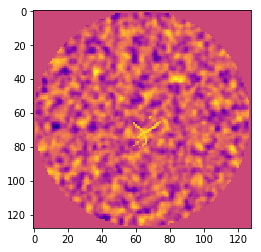

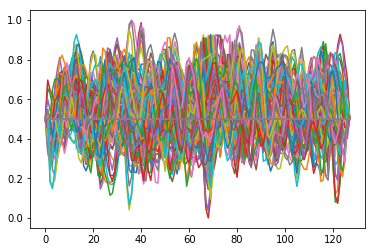

In [48]:
idx = 1
plt.imshow(data_fullfield[idx,:,:])
print(i_offset[idx], j_offset[idx], label[idx])
plt.show()
#f = plt.plot(Normalize()(data_fullfield[idx,:,:]).detach().numpy())
f = plt.plot(data_fullfield[idx,:,:].detach().numpy())

In [49]:
idx_start, idx_stop = 0, 20

#from main_orig import init
#args = init()
#args.N_azimuth * args.N_eccentricity

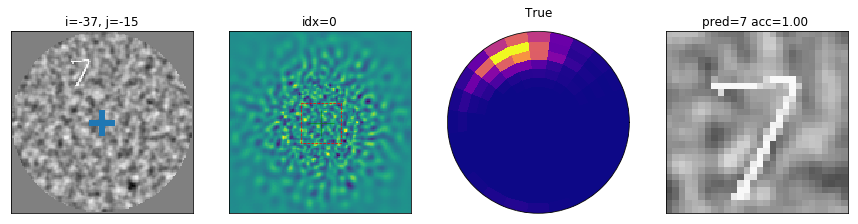

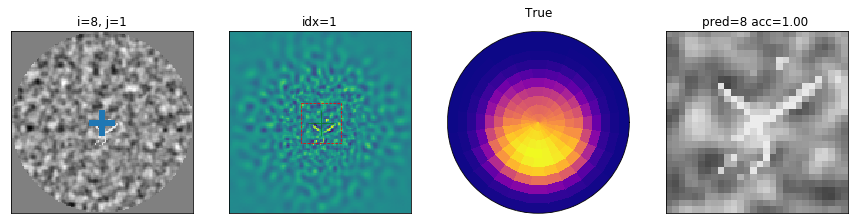

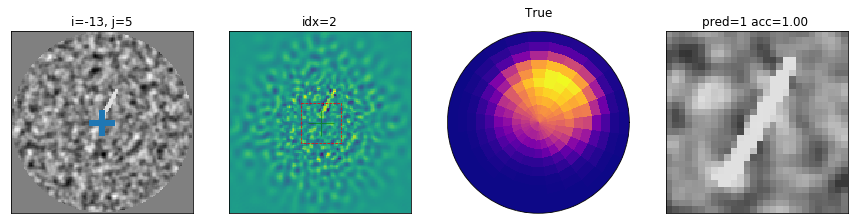

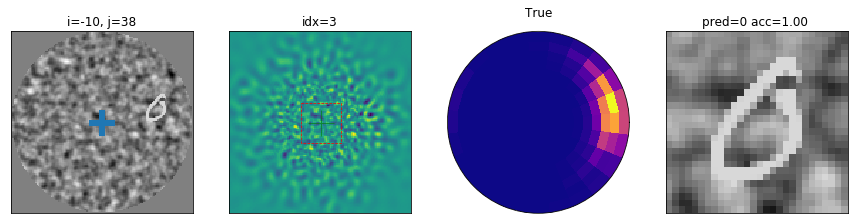

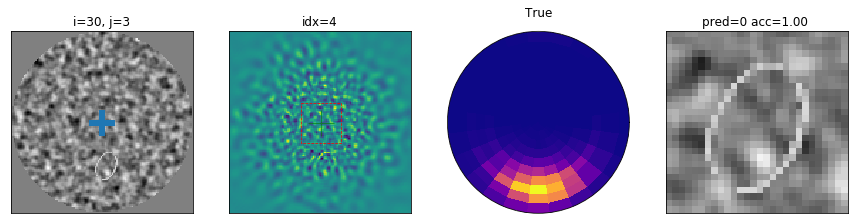

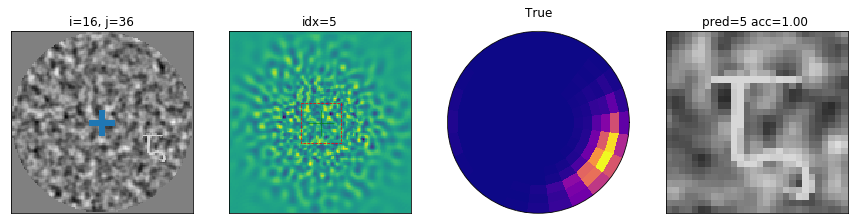

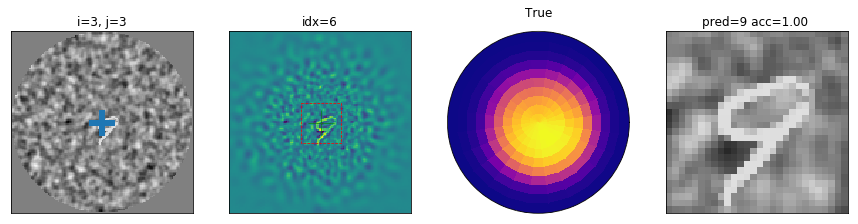

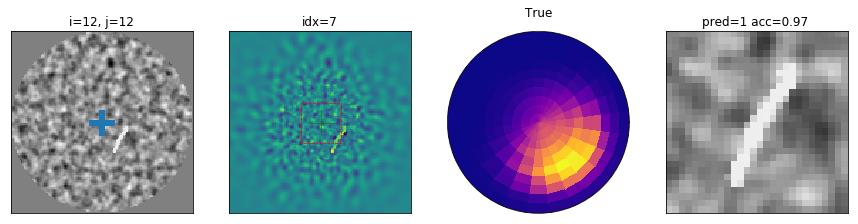

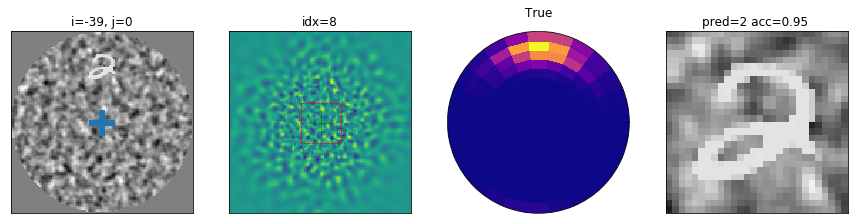

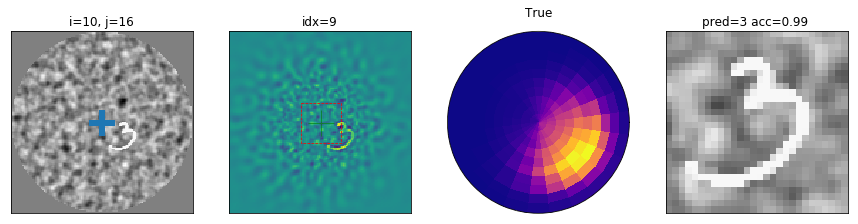

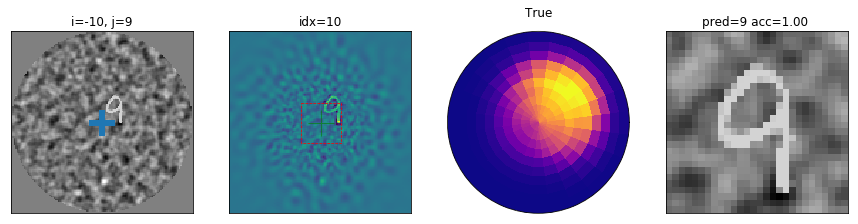

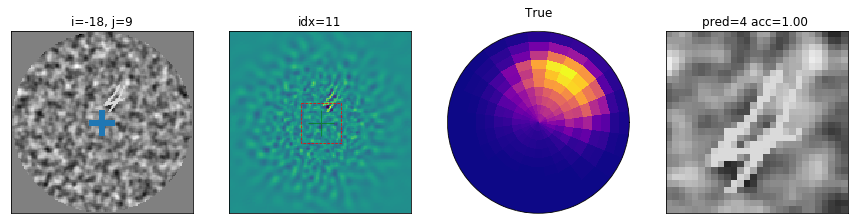

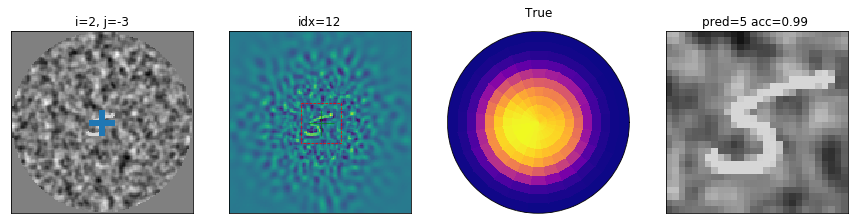

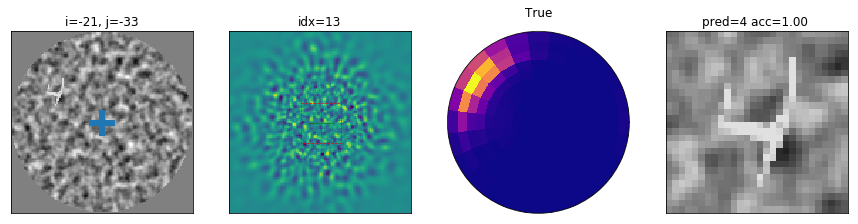

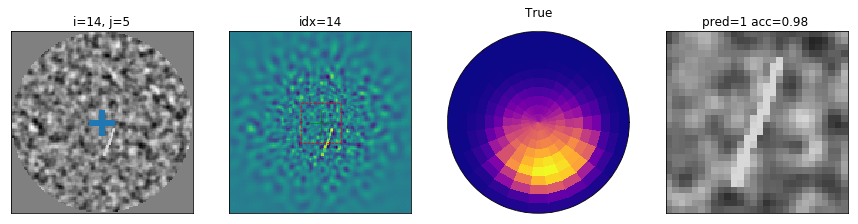

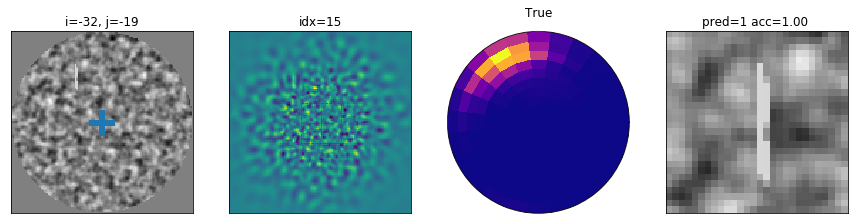

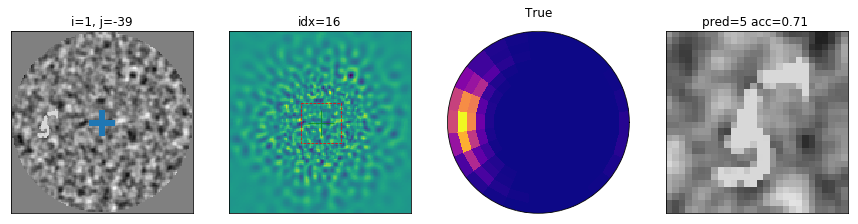

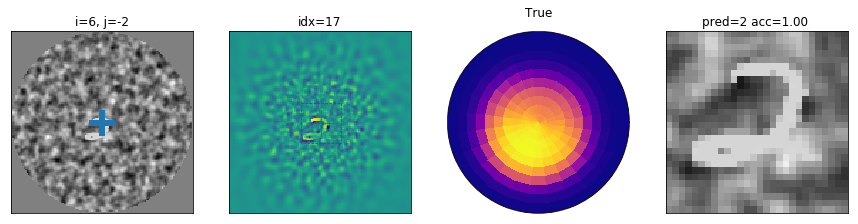

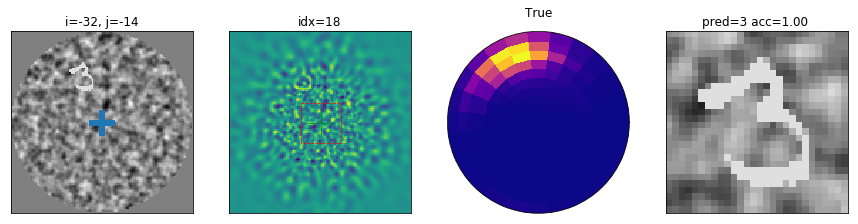

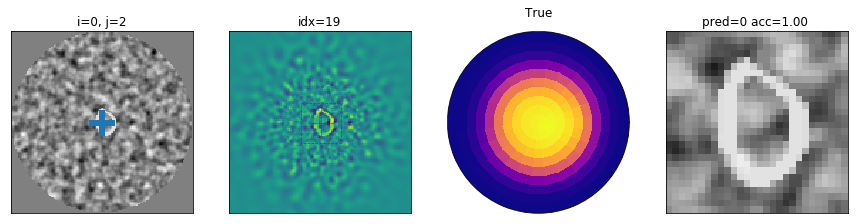

In [50]:
for idx in range(idx_start, idx_stop):
    fig = plt.figure(figsize = (15, 8))
    
    ax = fig.add_subplot(141)
    ax = where.display.show(ax, data_fullfield[idx, :, :])
    #ax.set_title(f"i={positions[idx]['i_offset']}, j={positions[idx]['j_offset']}")
    ax.set_title(f"i={i_offset[idx]}, j={j_offset[idx]}")
    
    ax = fig.add_subplot(142)
    data_retina = where.retina.retina(data_fullfield[idx, :, :])
    ax = where.retina.show(ax, where.retina.retina_invert(data_retina))
    ax.set_title(f"idx={idx}")
              
    ax = fig.add_subplot(143, projection='polar')
    ax.pcolor(where.retina.theta_grid, where.retina.log_r_grid, accuracy_colliculus[idx, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title("True")

    ax = fig.add_subplot(144)
    ax = where.display.show(ax, im[idx, :, :], do_cross=False)
    result = '' if pred[idx]==label[idx].numpy() else 'FALSE'
    ax.set_title(f"pred={pred[idx]} acc={proba[idx,pred[idx]]:.2f} {result}")
                 

## predicting the position of the target

In [51]:
pred_accuracy_colliculus = where.pred_accuracy(retina_data)
print('pred_accuracy_colliculus.shape=', pred_accuracy_colliculus.shape)

pred_accuracy_colliculus.shape= (100, 240)


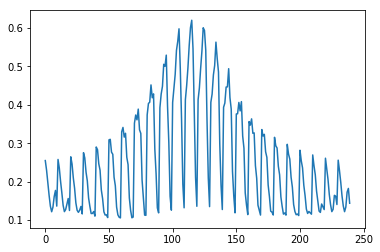

In [52]:
plt.plot(pred_accuracy_colliculus[2,:])

In [53]:
im_colliculus = where.retina.accuracy_invert(pred_accuracy_colliculus[0,:])
im_colliculus.shape

(128, 128)

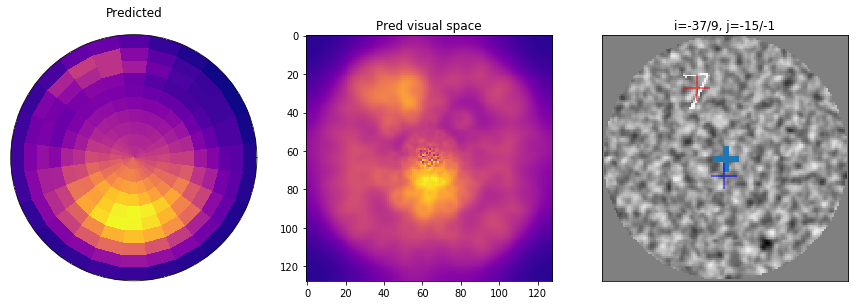

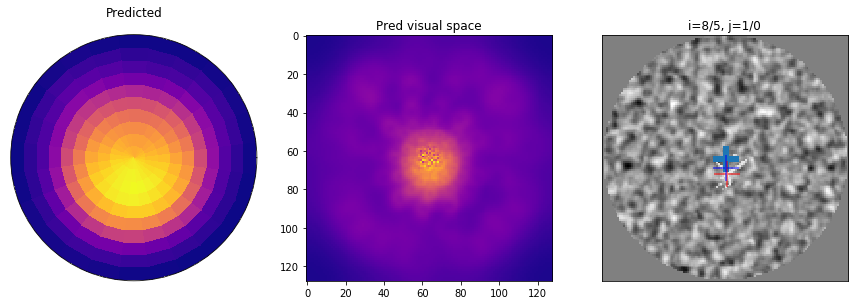

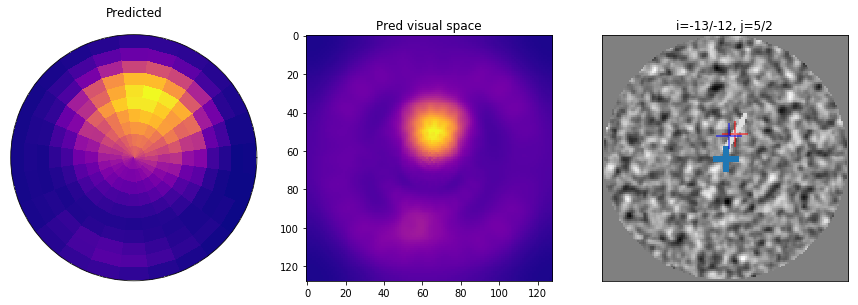

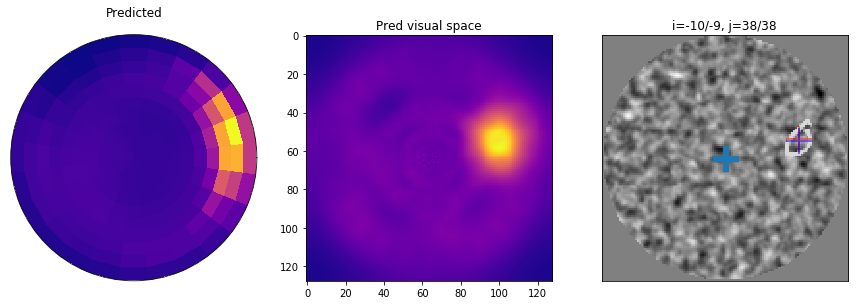

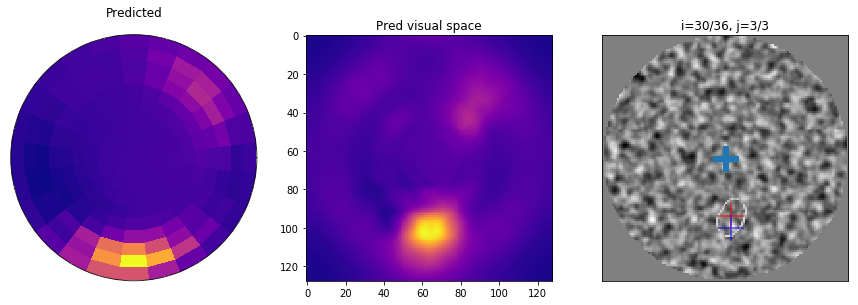

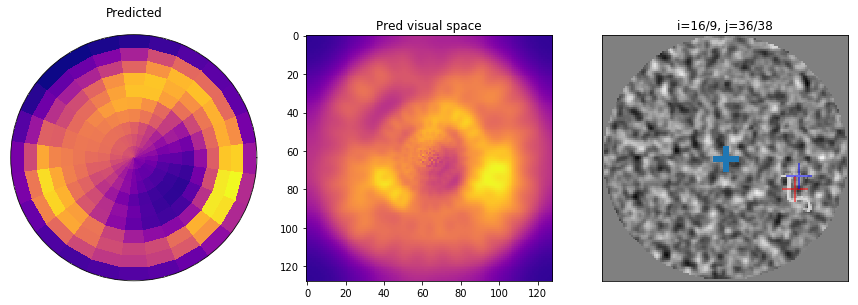

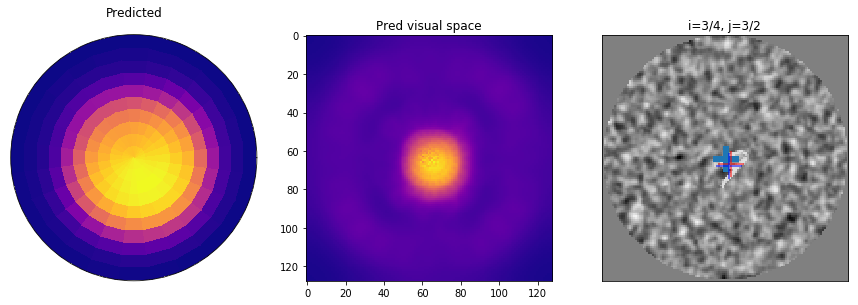

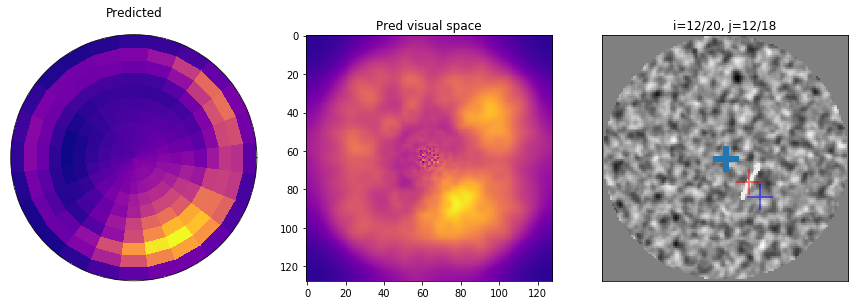

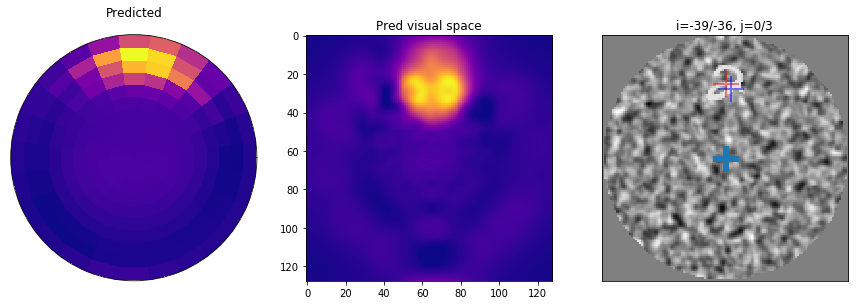

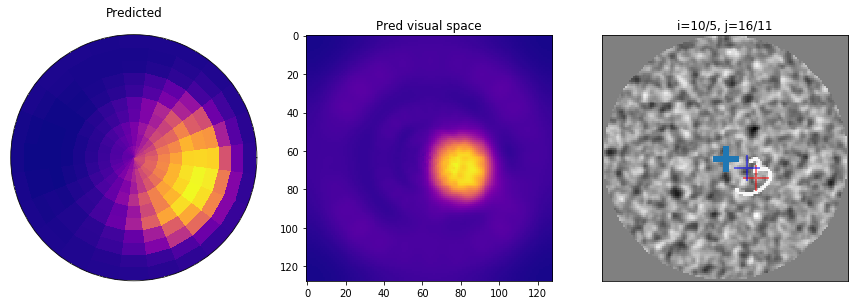

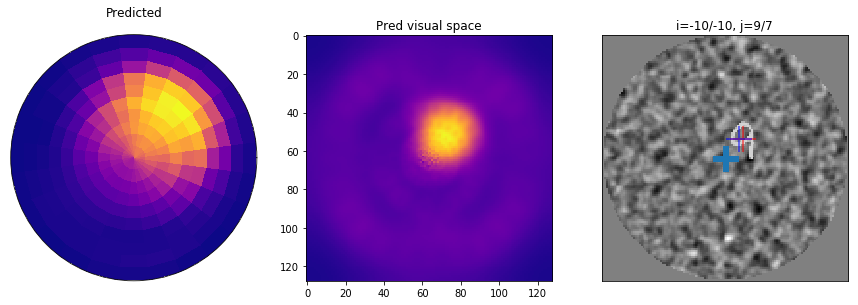

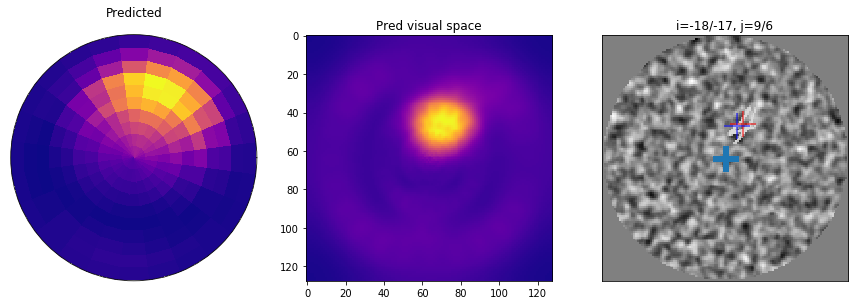

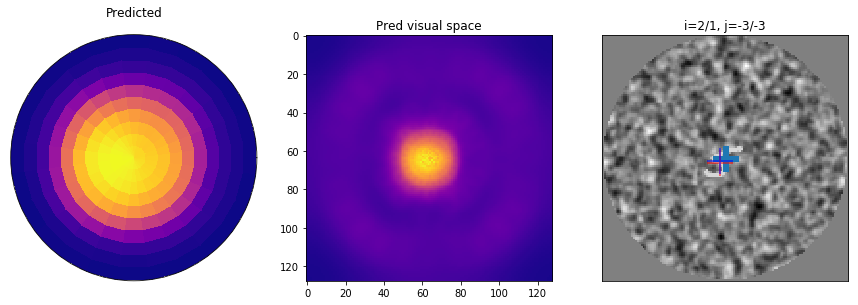

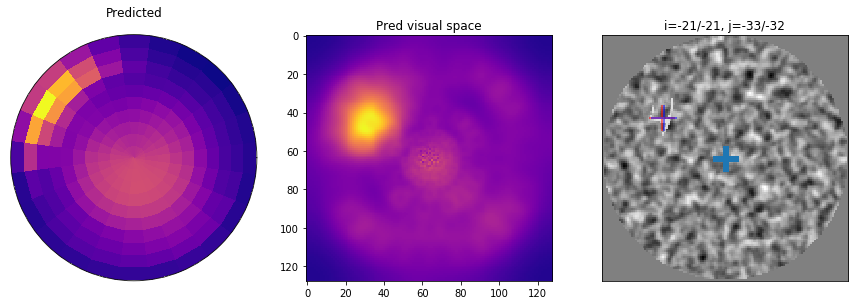

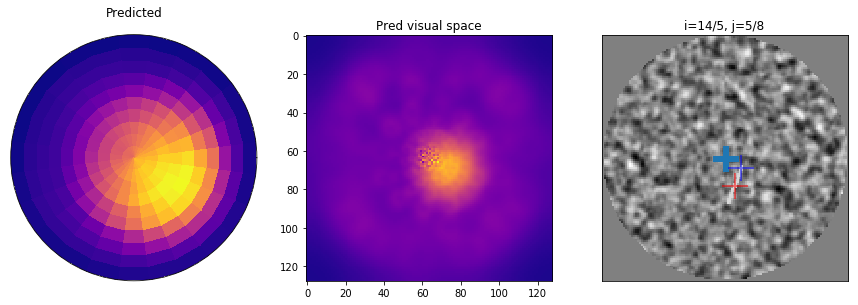

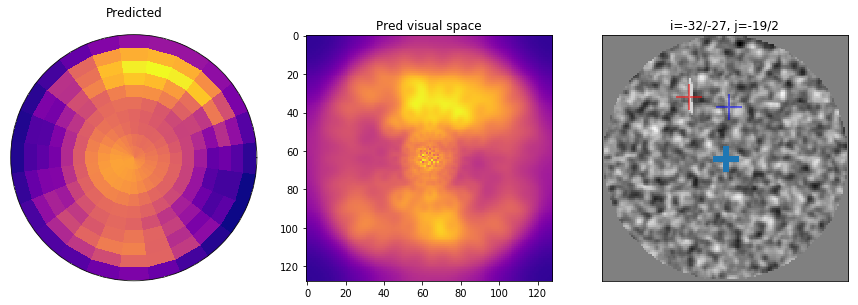

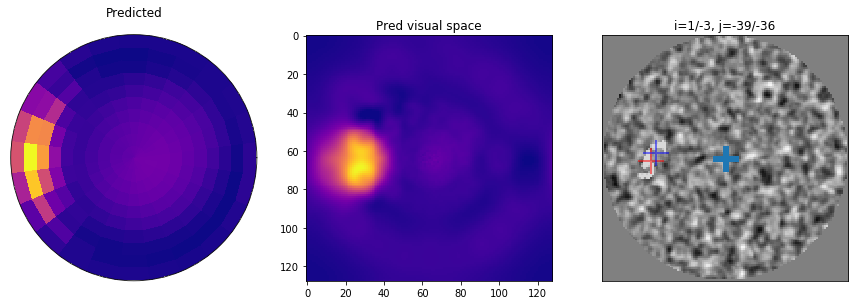

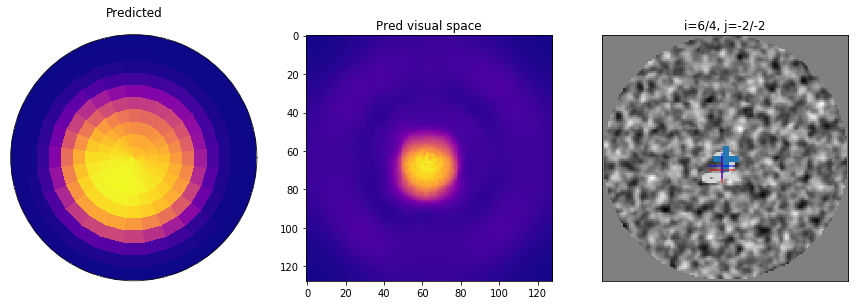

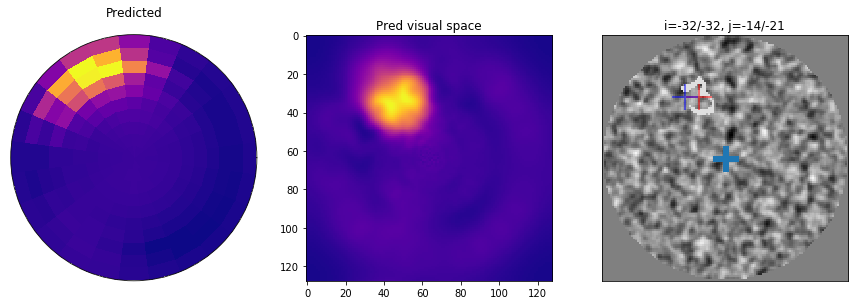

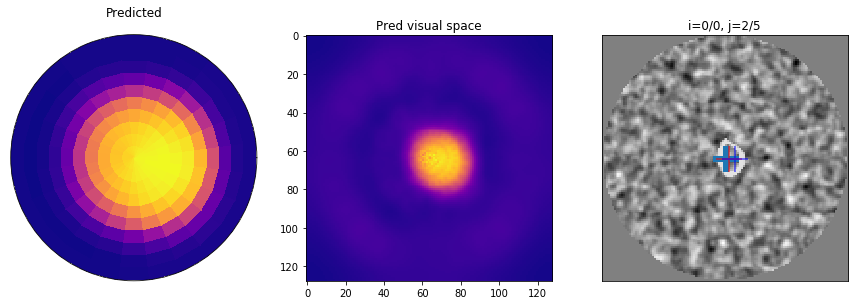

In [54]:
for idx in range(idx_start, idx_stop):
    fig = plt.figure(figsize = (15, 8))

    ax = fig.add_subplot(131, projection='polar')
    ax.pcolor(where.retina.theta_grid, where.retina.log_r_grid, pred_accuracy_colliculus[idx, :].reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    ax.set_title("Predicted")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
              
    x = where.retina.accuracy_invert(pred_accuracy_colliculus[idx, :])
    ax = fig.add_subplot(132)
    ax.imshow(x, vmin=0, cmap=plt.plasma())
    ax.set_title("Pred visual space")
    
    i_pred, j_pred = where.index_prediction(pred_accuracy_colliculus[idx, :], do_shortcut=True)
    
    ax = fig.add_subplot(133)
    ax = where.display.show(ax, data_fullfield[idx, :, :])
    #ax.set_title(f"i={positions[idx]['i_offset']}/{i_pred}, j={positions[idx]['j_offset']}/{j_pred}")
    ax.set_title(f"i={i_offset[idx]}/{i_pred}, j={j_offset[idx]}/{j_pred}")
    #ax.plot([positions[idx]['j_offset']+args.N_pic//2], [positions[idx]['i_offset']+args.N_pic//2], '+', c='r', ms=26, markeredgewidth=2, alpha=.5)
    ax.plot([j_offset[idx]+args.N_pic//2], [i_offset[idx]+args.N_pic//2], '+', c='r', ms=26, markeredgewidth=2, alpha=.5)
    ax.plot([j_pred+args.N_pic//2], [i_pred+args.N_pic//2], '+', c='b', ms=26, markeredgewidth=2, alpha=.5)
    
    

## doing a saccade at the predicted the position of the target

In [55]:
print(data_fullfield.shape, retina_data.shape, label.shape)

torch.Size([100, 128, 128]) torch.Size([100, 2880]) torch.Size([100])


In [56]:
accuracy = where.test_what(data_fullfield, pred_accuracy_colliculus, label)
#print('mean accuracy =', accuracy.mean())
accuracy

array([0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [57]:
where.what_class(data_fullfield, pred_accuracy_colliculus)

array([1, 8, 1, 0, 5, 7, 9, 7, 2, 3, 9, 4, 5, 4, 1, 1, 8, 2, 3, 0, 1, 3,
       6, 5, 6, 6, 3, 8, 1, 1, 2, 4, 0, 4, 0, 5, 4, 5, 6, 4, 2, 2, 4, 0,
       1, 6, 0, 4, 1, 4, 1, 1, 8, 5, 7, 9, 0, 6, 9, 8, 9, 8, 6, 7, 9, 4,
       9, 3, 0, 0, 2, 0, 8, 7, 6, 1, 1, 9, 8, 7, 9, 2, 1, 2, 3, 1, 7, 2,
       4, 9, 8, 6, 7, 8, 8, 0, 2, 2, 3, 8])

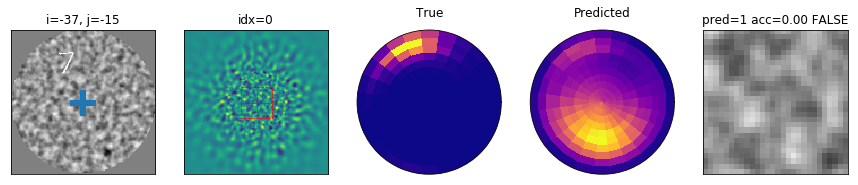

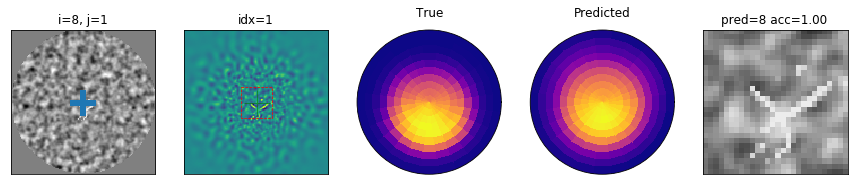

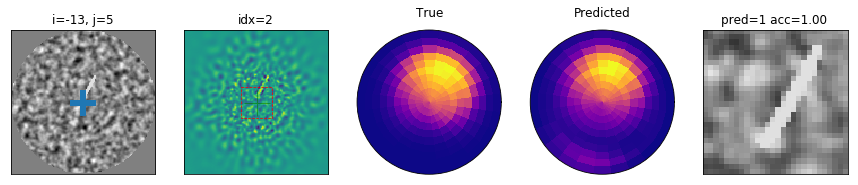

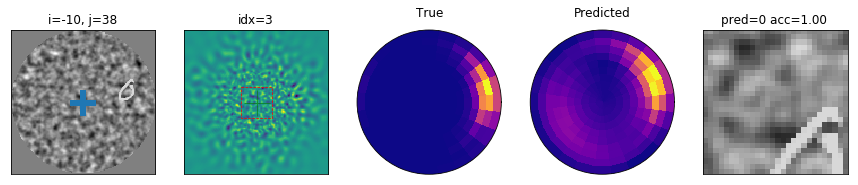

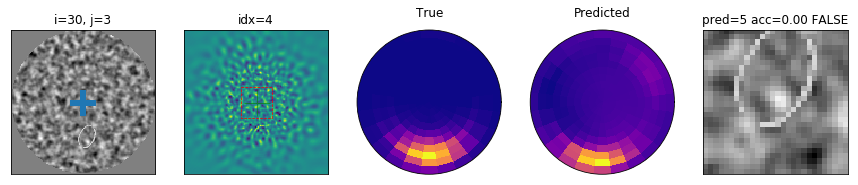

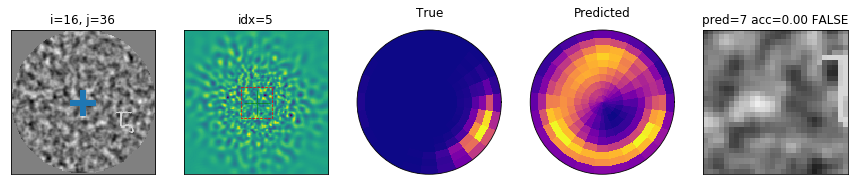

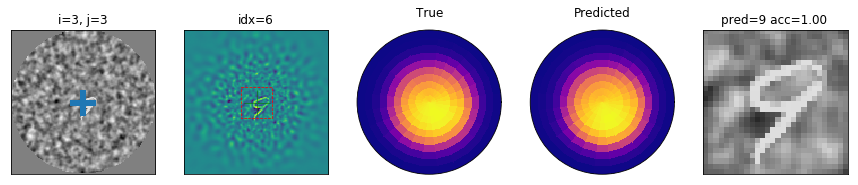

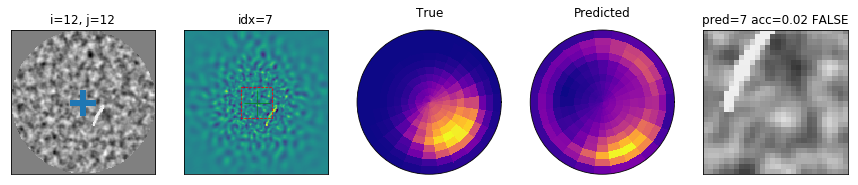

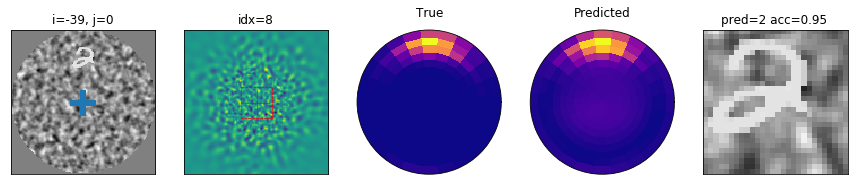

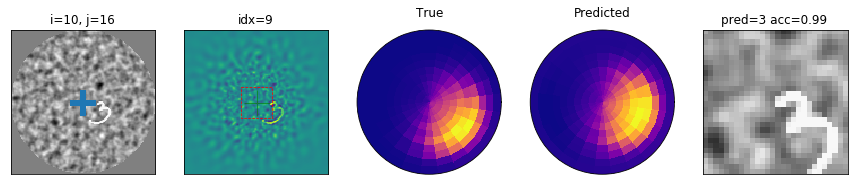

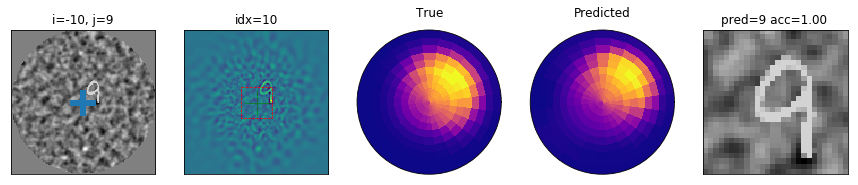

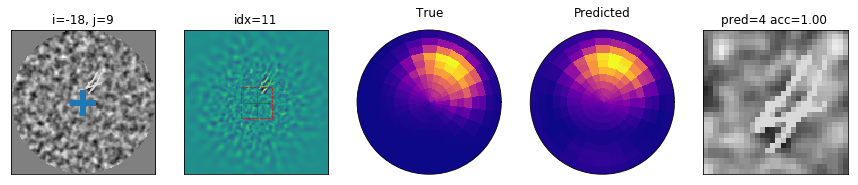

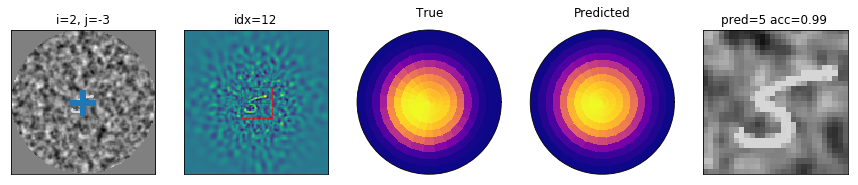

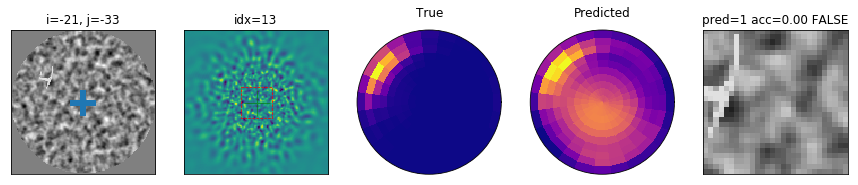

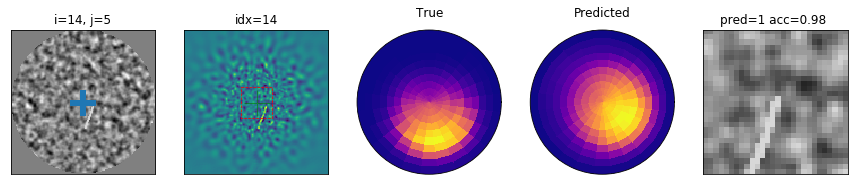

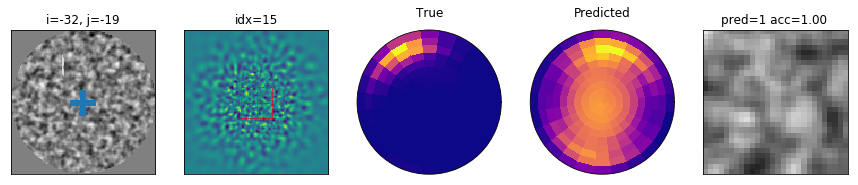

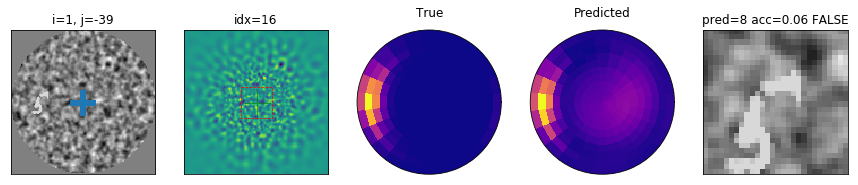

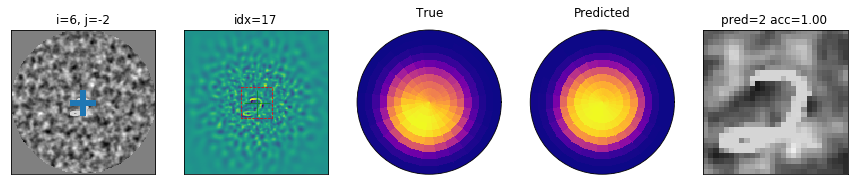

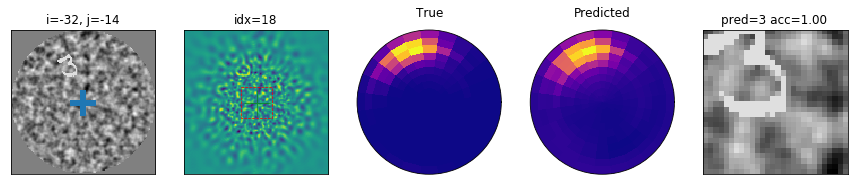

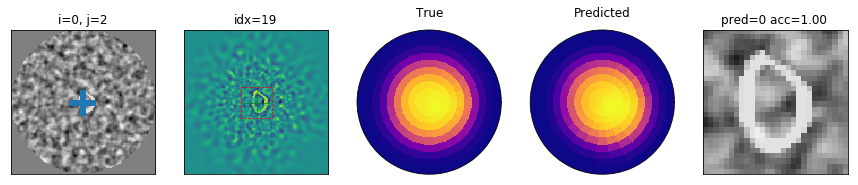

In [58]:
from display import minmax
pred_accuracy_colliculus = where.pred_accuracy(retina_data)
pred = where.what_class(data_fullfield, pred_accuracy_colliculus)
for idx in range(idx_start, idx_stop):
    fig = plt.figure(figsize = (15, 8))
    
    ax = fig.add_subplot(151)
    ax = where.display.show(ax, data_fullfield[idx, :, :])
    #ax.set_title(f"i={positions[idx]['i_offset']}, j={positions[idx]['j_offset']}")
    ax.set_title(f"i={i_offset[idx]}, j={j_offset[idx]}")
    
    ax = fig.add_subplot(152)
    data_retina = where.retina.retina(data_fullfield[idx, :, :])
    ax = where.retina.show(ax, where.retina.retina_invert(data_retina))
    ax.set_title(f"idx={idx}")
              
    ax = fig.add_subplot(153, projection='polar')
    ax.pcolor(where.retina.theta_grid, where.retina.log_r_grid, accuracy_colliculus[idx, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title("True")

    ax = fig.add_subplot(154, projection='polar')
    ax.pcolor(where.retina.theta_grid, where.retina.log_r_grid, pred_accuracy_colliculus[idx, :].reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title("Predicted")

    #i_pred, j_pred = where.index_prediction(pred_accuracy_colliculus[idx, :])
    i_pred, j_pred = where.index_prediction(pred_accuracy_colliculus[idx, :], do_shortcut=True)
    ax = fig.add_subplot(155)                 
    ax = where.display.show(ax, where.extract(data_fullfield[idx, :, :], i_pred, j_pred), do_cross=False)
    result = '' if pred[idx]==label[idx].numpy() else 'FALSE'
    ax.set_title(f"pred={pred[idx]} acc={proba[idx,pred[idx]]:.2f} {result}")
                 

testing on the test set:

# accuracy as a function of eccentricity


In [69]:
ecc_max=.8
N_eccentricities = args.N_eccentricity - 1
#eccentricities = args.N_pic / 2 * ecc_max * (1/args.rho)**(args.N_eccentricity - np.arange(N_eccentricities))
eccentricities = np.linspace(where.args.offset_max, 0, N_eccentricities, endpoint=False)

In [70]:
eccentricities

array([40.        , 35.55555556, 31.11111111, 26.66666667, 22.22222222,
       17.77777778, 13.33333333,  8.88888889,  4.44444444])

In [74]:
def test_eccentricities(N_eccentricities=9, ecc_max=.8, do_control=False, linear=False):
    import torch
    from torchvision import datasets, transforms
    from torch.utils.data import TensorDataset, DataLoader
    from where import RetinaFill, CollFill, WhereShift, RetinaBackground, RetinaMask, FullfieldRetinaWhiten 
    from where import FullfieldRetinaTransform, FullfieldToFloatTensor, Normalize, MNIST
    from where import FullfieldCollTransform
    if linear:
        eccentricities = np.linspace(where.args.offset_max, 0, N_eccentricities, endpoint=False)
    else:
        eccentricities = args.N_pic / 2 * ecc_max * (1/args.rho)**(args.N_eccentricity - np.arange(N_eccentricities))
    #eccentricities = np.linspace(where.args.offset_max, 0, N_eccentricities, endpoint=False)
    batch_size = 1000 #where.args.test_batch_size # data.shape[0]
    #from retina import get_data_loader
    #loader_test = get_data_loader(batch_size=1, train=False, 
    #                              mean=where.args.mean, std=where.args.std, seed=where.args.seed+10)
        
    accuracy_mean, accuracy_std = [], []
    for eccentricity in eccentricities:
        print(eccentricity)
        fullfield_transform = transforms.Compose([
            RetinaFill(N_pic=args.N_pic),
            WhereShift(args, radius = eccentricity),
            RetinaBackground(contrast=args.contrast,
                             noise=args.noise,
                             sf_0=args.sf_0,
                             B_sf=args.B_sf),
            RetinaMask(N_pic=args.N_pic),
            FullfieldRetinaWhiten(N_pic=args.N_pic),
            FullfieldRetinaTransform(where.retina.retina_transform_vector),
            FullfieldToFloatTensor(),
            #Normalize(fullfield=True)
            # transforms.Normalize((args.mean,), (args.std,))
        ])
        fullfield_target_transform=transforms.Compose([
                               CollFill(where.accuracy_map, keep_label = True, N_pic=args.N_pic, baseline=0.1),
                               WhereShift(args, baseline = 0.1, keep_label = True),
                               FullfieldCollTransform(where.retina.colliculus_transform_vector, keep_label = True),
                               FullfieldToFloatTensor(keep_label = True)
                           ])
        dataset = MNIST('../data',
                        train=False,
                        download=True,
                        transform=fullfield_transform,
                        target_transform=fullfield_target_transform,
                        )
        data_loader = DataLoader(dataset,
                                 batch_size=batch_size,
                                 shuffle=True)

        '''retina_data = np.zeros((batch_size, where.retina.vsize))
        labels = np.zeros((batch_size))
        data_fullfield = np.zeros((batch_size, where.args.N_pic, where.args.N_pic))        
        accuracy_colliculus = np.zeros((batch_size, where.args.N_azimuth * where.args.N_eccentricity))

        for i in range(batch_size):
            data, label = next(iter(loader_test))
            data_fullfield[i, :, :], i_offset, j_offset = where.display.draw(data[0, 0, :, :].numpy(), 
                                                                   radius=eccentricity)
            positions.append(dict(i_offset=i_offset, j_offset=j_offset))
            retina_data[i, :]  =  where.retina.retina(data_fullfield[i, :, :])
            labels[i] = label
        labels =  Variable(torch.FloatTensor(labels))
        retina_data =  Variable(torch.FloatTensor(retina_data))
        pred_accuracy_colliculus = where.pred_accuracy(retina_data)'''
        
        if nb_saccades >1 and not do_control:
            print('ok')
            accuracy = where.multi_test(nb_saccades, dataloader=data_loader)
            accuracy_mean.append(accuracy)
        else:
            data, acc = next(iter(data_loader))
            retina_data = data[0]
            data_fullfield = data[1]
            labels = acc[2]
            pred_accuracy_colliculus = where.pred_accuracy(retina_data)
            accuracy_ = where.test_what(data_fullfield, pred_accuracy_colliculus, labels.squeeze(), do_control=do_control)
            accuracy_mean.append(accuracy_.mean())
            accuracy_std.append(accuracy_.std()) # TODO fit with beta distribution'''
        
        
    return eccentricities, np.array(accuracy_mean), np.array(accuracy_std)

In [79]:
from where import where_suffix
import os
suffix = where_suffix(args, robust=True)
if linear:
    file_path = '/tmp/eccentricity_accuracy_linear_{}_{}.npy'.format(suffix, nb_saccades)
else:
    file_path = '/tmp/eccentricity_accuracy_{}_{}.npy'.format(suffix, nb_saccades)
if True : #os.path.isfile(file_path):
    eccentricities, accuracy_mean, accuracy_std = test_eccentricities(N_eccentricities, linear=linear)
    print('eccentricities=', eccentricities, ', accuracy_data=', accuracy_mean, ' +/- ', accuracy_std)
    eccentricities, ctl_accuracy_mean, ctl_accuracy_std = test_eccentricities(N_eccentricities, linear=linear, do_control=True)
    print('eccentricities=', eccentricities, ', ctl_accuracy_data=', ctl_accuracy_mean, ' +/- ', ctl_accuracy_std)
    np.save(file_path,[eccentricities, accuracy_mean, ctl_accuracy_mean])
else:
    data = np.load(file_path)
    eccentricities = data[0]
    accuracy_mean = data[1]
    ctl_accuracy_mean = data[2]

40.0
35.55555555555556
31.11111111111111
26.666666666666664
22.22222222222222
17.77777777777778
13.333333333333332
8.888888888888886
4.444444444444443
eccentricities= [40.         35.55555556 31.11111111 26.66666667 22.22222222 17.77777778
 13.33333333  8.88888889  4.44444444] , accuracy_data= [0.634 0.732 0.761 0.79  0.83  0.861 0.873 0.907 0.897]  +/-  [0.48170946 0.4429176  0.42647274 0.40730824 0.3756328  0.34594653
 0.33297297 0.29043244 0.30395888]
40.0
35.55555555555556
31.11111111111111
26.666666666666664
22.22222222222222
17.77777777777778
13.333333333333332
8.888888888888886
4.444444444444443
eccentricities= [40.         35.55555556 31.11111111 26.66666667 22.22222222 17.77777778
 13.33333333  8.88888889  4.44444444] , ctl_accuracy_data= [0.117 0.115 0.115 0.115 0.174 0.367 0.597 0.791 0.901]  +/-  [0.32142029 0.31902194 0.31902194 0.31902194 0.37910948 0.48198651
 0.49050076 0.40659439 0.29866202]


In [78]:
os.path.isfile(file_path)

False

In [80]:
accuracy_mean

array([0.634, 0.732, 0.761, 0.79 , 0.83 , 0.861, 0.873, 0.907, 0.897])

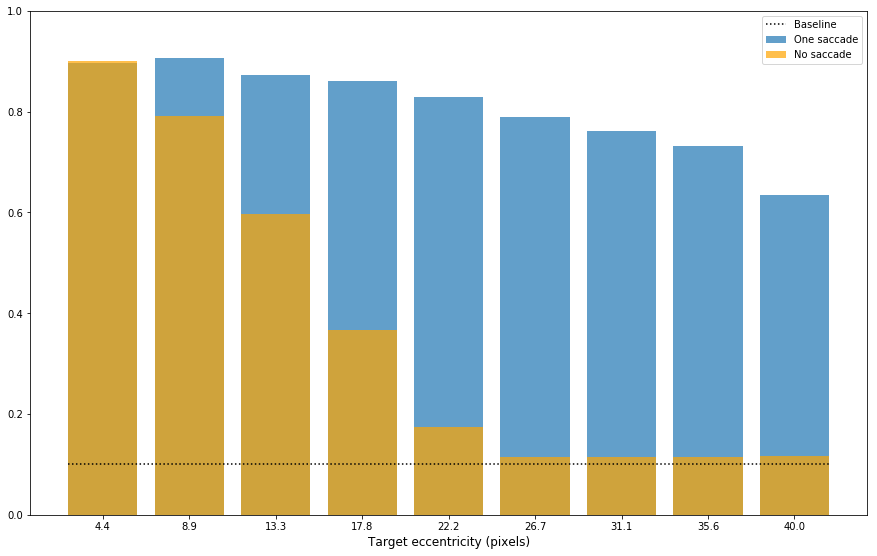

In [81]:
figwidth = 15
fig = plt.figure(figsize = (figwidth, figwidth/1.618))
ax_D = fig.add_subplot(1, 1, 1)
width = .8*np.abs(np.gradient(eccentricities)[0])
ax_D.bar(eccentricities, accuracy_mean, width=width, alpha = .7, label = 'One saccade')#yerr=accuracy_std, 
# TODO what instead? ax_D.bar(eccentricities, accuracy_data, alpha = .5, label = 'No saccade') #accuracy_map[27,27:55])
ax_D.bar(eccentricities, ctl_accuracy_mean, width=width, color='orange', alpha = .7, label = 'No saccade')
ax_D.plot([eccentricities.min()-width/2, eccentricities.max()+width/2], [0.1]*2, ':', c='k', label = 'Baseline')
plt.legend(loc='best')
#ax_D.set_title('Class accuracy', fontsize = 14)
ax_D.set_xlabel('Target eccentricity (pixels)', fontsize = 12)
ax_D.set_xticks(eccentricities)
ax_D.set_xticklabels(['%.1f' % d for  d in eccentricities])
ax_D.set_ylim([0,1]);

# summary


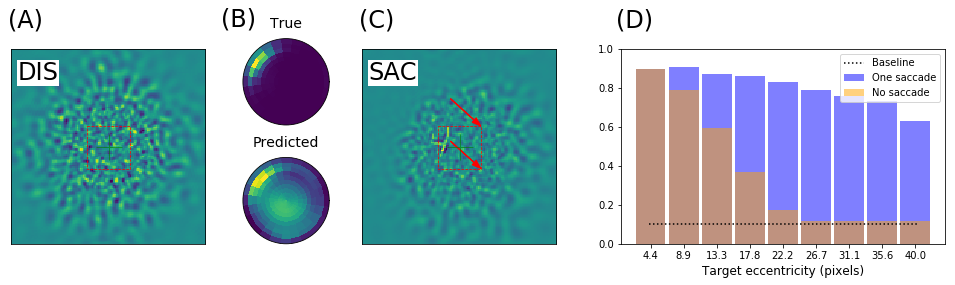

In [86]:
from where import WhereShift
idx = 13
fullfield = data_fullfield[idx, :, :]

fig = plt.figure(figsize = (figwidth, figwidth/2.5))#1.618))
ax_A = plt.subplot(1, 4, 1) 
data_retina = where.retina.retina(fullfield)
ax_A = where.retina.show(ax_A, where.retina.retina_invert(data_retina))
    
ax_B = plt.subplot(2, 4, 2, projection='polar', autoscale_on=False)
ax_B.pcolor(where.retina.theta_grid, where.retina.log_r_grid, accuracy_colliculus[idx, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)))
ax_B.grid('off')
plt.title('True', fontsize = 14)
ax_B.set_yticklabels([])
ax_B.set_xticklabels([])

ax_Bb = plt.subplot(2, 4, 6, projection='polar')
ax_Bb.pcolor(where.retina.theta_grid, where.retina.log_r_grid, pred_accuracy_colliculus[idx, :].reshape((args.N_azimuth, args.N_eccentricity)))
ax_Bb.set_title('Predicted', fontsize = 14)
ax_Bb.set_yticklabels([])
ax_Bb.set_xticklabels([])

ax_C = plt.subplot(1, 4, 3)
#data_fullfield_ = where.display.place_object(data[idx, 0, :, :].numpy(), 0, 0)
i_pred, j_pred = where.index_prediction(pred_accuracy_colliculus[idx, :])
data_fullfield_ = WhereShift(args, i_offset=-i_pred, j_offset=-j_pred, baseline=0.5)((fullfield, 0)) 
input_vector  =  where.retina.retina(data_fullfield_)
ax_C = where.retina.show(ax_C, where.retina.retina_invert(input_vector))
#ax_A.arrow(64.5, 64.5, j_pred, i_pred, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')
ax_C.arrow(args.N_pic//2+j_pred+14, args.N_pic//2+i_pred+14, -j_pred, -i_pred, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')
ax_C.arrow(args.N_pic//2+j_pred+14, args.N_pic//2+i_pred-14, -j_pred, -i_pred, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')

ax_D = plt.subplot(1, 4, 4)
#width = .8*np.abs(np.gradient(eccentricities)[0])
if not linear:
    width = .3*np.abs(eccentricities)
else:
    width = 4
ax_D.bar(eccentricities, accuracy_mean, width=width, color='blue', alpha = .5, label = 'One saccade')
ax_D.bar(eccentricities, ctl_accuracy_mean, width=width, color='orange', alpha = .5, label = 'No saccade')
width = .5
ax_D.plot([eccentricities.min()-width/2, eccentricities.max()+width/2], [0.1]*2, ':', c='k', label = 'Baseline')
#ax_D.plot([eccentricities.min()-width/2, eccentricities.max()+width/2], [acc_max]*2, ':', c='k', label = 'Max')

plt.legend(loc='upper right')
ax_D.set_xlabel('Target eccentricity (pixels)', fontsize = 12)
ax_D.set_ylim([0,1])
if not linear:
    ax_D.set_xscale('log')
ax_D.set_xticks(eccentricities)
ax_D.set_xticklabels(['%.1f' % d for  d in eccentricities])
if not linear:
    ax_D.set_xlim([1.3,30])

for ax, text in [[ax_A, 'DIS'], [ax_C, 'SAC']]:
    ax.text(4, 15, text, fontsize=24,
          bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
          ha='left', va='center') 

offset = -.015
for ax, text, x_offset, y_offset in [[ax_A, 'A', offset, 1.15], [ax_B, 'B', -.25, 1.225], [ax_C, 'C', offset, 1.15], [ax_D, 'D', offset, 1.15]]:
    ax.text(x_offset, y_offset, '(' + text + ')', fontsize=24,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center', transform=ax.transAxes) 

# pos : [left, bottom, width, height] =    The new position of the in `.Figure` coordinates.    
plt.tight_layout()
ax_A.set_position([0.025, 0.1, .3, .45])
ax_B.set_position( [0.24, 0.375, .2, 0.2])
ax_Bb.set_position([0.24, 0.1, .2, 0.2])
ax_C.set_position([0.35, .1, .3, .45])
ax_D.set_position([0.65, .1, .3, .45])
fig.savefig(figname + '.pdf', bbox_inches='tight', pad_inches=0.1)

In [ ]:
_ = plt.plot(fullfield.detach().numpy())

# post-processing

In [ ]:
!convert  -density {dpi_export} {figname}.pdf {figname}.jpg
!convert  -density {dpi_export} {figname}.pdf {figname}.png
#!convert  -density {dpi_export} -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 {fname}.pdf {fname}.tiff

In [ ]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

In [ ]:
!ls  -l {figname}*